In [1]:
import re
import warnings

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import MiniBatchKMeans

from utils import *

%matplotlib inline
plt.style.use('ggplot')
warnings.filterwarnings('ignore')

In [2]:
def sentences(s_list):
    words = split_on_word(s_list)
    words_norm = normalize(words)
    return [' '.join(s) for s in words_norm]

---

In [3]:
essay = 'essay5'

In [4]:
TAG_RE = re.compile(r'<[^>]+>')

df = pd.read_csv('data/profiles.20120630.csv')
df = df[~df[essay].isnull()]

essays = ['essay' + str(i) for i in range(10)]
for e in essays:
    df[e] = df[e].replace(np.nan, '' , regex=True)    \
                 .replace('\n', ' ')                  \
                 .apply(lambda x: TAG_RE.sub(' ', x)) \
                 .apply(lambda x: re.sub('\s+', ' ', x).strip())

df.fillna('', inplace=True)
df['ethnicity_'] = df.ethnicity.apply(lambda x: 'mixed' if ',' in x else x)

---

In [5]:
df_sample = df.sample(10000, random_state=1868)

---

In [6]:
sents = sentences(df_sample[essay].tolist())

---

In [7]:
tfidf = TfidfVectorizer()
M = tfidf.fit_transform(sents)

In [8]:
cosine_score = cosine_similarity(M, M)

---

In [9]:
K = 4

In [10]:
mb_kmeans = MiniBatchKMeans(n_clusters=K, random_state=1868)
mb_kmeans

MiniBatchKMeans(batch_size=100, compute_labels=True, init='k-means++',
        init_size=None, max_iter=100, max_no_improvement=10, n_clusters=4,
        n_init=3, random_state=1868, reassignment_ratio=0.01, tol=0.0,
        verbose=0)

In [11]:
mb_kmeans.fit(cosine_score)

MiniBatchKMeans(batch_size=100, compute_labels=True, init='k-means++',
        init_size=None, max_iter=100, max_no_improvement=10, n_clusters=4,
        n_init=3, random_state=1868, reassignment_ratio=0.01, tol=0.0,
        verbose=0)

In [12]:
df_sample['kmeans'] = mb_kmeans.labels_

---

In [13]:
df_sample.ethnicity_.value_counts()

white               5654
mixed               1144
asian               1056
                     818
hispanic / latin     447
black                333
other                273
indian               159
pacific islander      59
middle eastern        48
native american        9
dtype: int64

In [14]:
for c in np.sort(df_sample.kmeans.unique()):
    if c == 0:
        tdf = df_sample[df_sample.kmeans == c]
        tdf_p = pd.DataFrame({str(c) :
                              tdf.ethnicity_.value_counts().sort_index()/\
                              tdf.ethnicity_.value_counts().sort_index().sum()}).reset_index()
    else:
        tdf = df_sample[df_sample.kmeans == c]
        tdf_p = pd.merge(tdf_p,
                         pd.DataFrame({str(c) :
                                       tdf.ethnicity_.value_counts().sort_index()/\
                                       tdf.ethnicity_.value_counts().sort_index().sum()}).reset_index(),
                         how='outer',
                         on='index')

tdf_p.fillna(0)
tdf_p.rename(columns={'index':'ethnicity_'}, inplace=True)

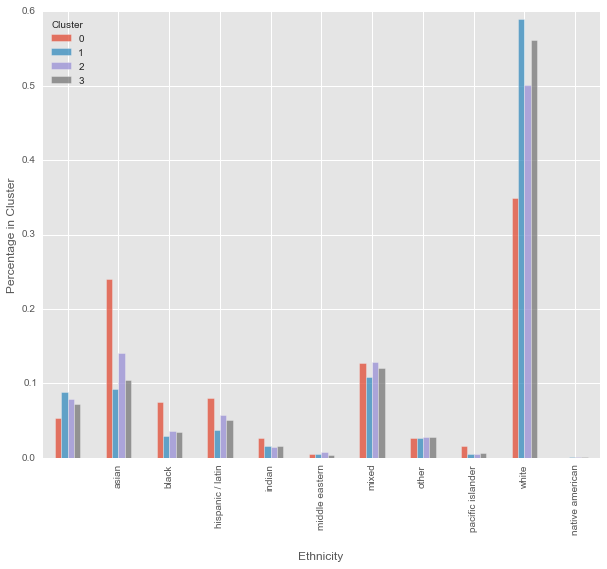

In [15]:
tdf_p.plot(alpha=0.75, figsize=(10, 8), kind='bar')

plt.xlim(-0.5, len(df_sample.ethnicity_.unique())-0.5)
plt.xticks(tdf_p.index, tdf_p.ethnicity_, rotation=90);

plt.xlabel('\nEthnicity')
plt.ylabel('Percentage in Cluster')

plt.legend(range(K), loc='upper left', title='Cluster')